In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t')
model = AutoModel.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t', trust_remote_code=True)

## Creating new tokenizer file with limit on max length of tokens. If you don't need, skip this section

In [ ]:
new_vocab = dict()
for token, token_id in tokenizer.get_vocab().items():
  if len(token) <= 5:
    new_vocab[token] = token_id

The file will be saved as 'tokenizer_new_2.json'. You need to substitute your original tokenizer.json file with a new one and rename the new file to tokenizer.json as well.

In [ ]:
import json

# Open and read the JSON file
with open('/content/gena-lm-bert-base-t2t/tokenizer.json') as f:
    data = json.load(f)
    data["model"]["vocab"] = new_vocab
    print(data['model']['merges'])
    merges = []
    for el in data['model']['merges']:
      try:
        item1, item2 = el.split(' ')
      except:
        print("HI:", el)
      if len(item1) + len(item2) <= 4:
        merges.append(f'{item1} {item2}')
    data["model"]["merges"] = merges
with open('tokenizer_new_2.json', 'w') as file_:
  json.dump(data, file_)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/content/gena-lm-bert-base-t2t')

In [ ]:
from torch import nn

## This block is for LORA finetuning. If you don't need it, skip it

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

In [ ]:
!pip install peft

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
!pip install optuna

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, #attention heads
    lora_alpha=32, #alpha scaling
    # target_modules=["q_proj", "v_proj"], #if you know the
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

## Продолжаем загрузку модели

In [ ]:
tokens = tokenizer.tokenize(seq, add_special_tokens=True)
print('tokens:', tokens)
print('n_tokens:', len(tokens))

tokens: ['[CLS]', 'C', 'ACCC', 'AGAG', 'AGAG', 'TAA', 'CC', 'AGAA', 'TGG', 'ATAC', 'ATT', 'TTGG', 'CC', 'AAC', 'ATG', 'ATTC', 'TAA', 'CCC', 'AGTG', 'AG', 'ACCC', 'ATT', 'TTGG', 'GC', 'TT', 'ATG', '[SEP]']
n_tokens: 27


In [ ]:
with torch.no_grad():
  output = model(**tokenizer(seq, return_tensors='pt'), output_hidden_states=True)
print(output.keys())

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


odict_keys(['logits', 'hidden_states'])


In [ ]:
output['hidden_states'][-1].shape

torch.Size([1, 14, 768])

In [ ]:
gena_module_name = model.__class__.__module__
print(gena_module_name)

transformers_modules.AIRI-Institute.gena-lm-bert-base-t2t.5d6fcf5291ad8f36597227cf2dbec20eb01a9979.modeling_bert


In [ ]:
import importlib
# available class names:
# - BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
# - BertForSequenceClassification, BertForMultipleChoice, BertForTokenClassification,
# - BertForQuestionAnswering
# check https://huggingface.co/docs/transformers/model_doc/bert
cls = getattr(importlib.import_module(gena_module_name), 'BertForSequenceClassification')
cls

transformers_modules.AIRI-Institute.gena-lm-bert-base-t2t.5d6fcf5291ad8f36597227cf2dbec20eb01a9979.modeling_bert.BertForSequenceClassification

In [ ]:
model = cls.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t', num_labels=2)
print('\nclassification head:', model.classifier)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AIRI-Institute/gena-lm-bert-base-t2t and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



classification head: Linear(in_features=768, out_features=2, bias=True)


## Let's download GUE dataset

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from datasets import load_dataset, get_dataset_config_names
print('imported')

imported


In [ ]:
config_names = get_dataset_config_names("leannmlindsey/GUE")
print(config_names)
dataset = load_dataset("leannmlindsey/GUE", name="prom_core_all")
dataset
dataset["train"][0]

['emp_H3', 'emp_H3K14ac', 'emp_H3K36me3', 'emp_H3K4me1', 'emp_H3K4me2', 'emp_H3K4me3', 'emp_H3K79me3', 'emp_H3K9ac', 'emp_H4', 'emp_H4ac', 'human_tf_0', 'human_tf_1', 'human_tf_2', 'human_tf_3', 'human_tf_4', 'mouse_0', 'mouse_1', 'mouse_2', 'mouse_3', 'mouse_4', 'prom_300_all', 'prom_300_notata', 'prom_300_tata', 'prom_core_all', 'prom_core_notata', 'prom_core_tata', 'splice_reconstructed', 'virus_covid', 'virus_species_40', 'fungi_species_20', 'EPI_K562', 'EPI_HeLa-S3', 'EPI_NHEK', 'EPI_IMR90', 'EPI_HUVEC', 'EPI_GM12878']


{'sequence': 'GCTAGCTCATCTTGCGGCTGGGCGGGGCCCAGGACTGCTGCTGCTGACCGCCTTGATAGGCTACACCGTG',
 'label': 1}

In [ ]:
print('# base pairs: ', len(dataset['train'][0]['sequence']))

# base pairs:  70


In [ ]:
print('tokens: ', ' '.join(tokenizer.tokenize(dataset['train'][0]['sequence'])))

tokens:  GC TAGC TC ATC TTGC GGC TGGG C GGGG CCC AGG AC TGC TGC TGC TG ACC GCC TTG AT AGGC TAC ACC GTG


In [ ]:
print('# tokens: ', len(tokenizer.tokenize(dataset['train'][0]['sequence'])))

# tokens:  24


In [ ]:
dataset['train'][0]

{'sequence': 'GCTAGCTCATCTTGCGGCTGGGCGGGGCCCAGGACTGCTGCTGCTGACCGCCTTGATAGGCTACACCGTG',
 'label': 1}

In [ ]:
def preprocess_function(examples):
  # just truncate right, but for some tasks symmetric truncation from left and right is more reasonable
  # set max_length to 128 tokens to make experiments faster
  return tokenizer(examples["sequence"], truncation=True, max_length=128)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'label'],
        num_rows: 47356
    })
    test: Dataset({
        features: ['sequence', 'label'],
        num_rows: 5920
    })
    dev: Dataset({
        features: ['sequence', 'label'],
        num_rows: 5920
    })
})

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/47356 [00:00<?, ? examples/s]

Map:   0%|          | 0/5920 [00:00<?, ? examples/s]

Map:   0%|          | 0/5920 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']

Dataset({
    features: ['sequence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 47356
})

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 47356
    })
    test: Dataset({
        features: ['sequence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5920
    })
    dev: Dataset({
        features: ['sequence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5920
    })
})

## Training

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
import evaluate
print('imported')

imported


In [ ]:
mcc = evaluate.load("matthews_correlation")

print('done')

done


In [ ]:
f1_metric = evaluate.load("f1")
print('done')

done


In [ ]:
precision_metric = evaluate.load("precision")
print('done')

done


In [ ]:
accuracy_metric = evaluate.load("accuracy")
print('done')

done


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': (predictions==labels).sum() / len(labels)} | precision_metric.compute(references=labels, predictions=predictions) | mcc.compute(predictions=predictions, references=labels) | f1_metric.compute(predictions=predictions, references=labels)

# change training hyperparameters to archive better quality
training_args = TrainingArguments(
    output_dir="test_run",
    learning_rate=2e-05,
    lr_scheduler_type="constant_with_warmup",
    warmup_ratio=0.1,
    optim='adamw_torch',
    weight_decay=0.0,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting training")
trainer.train()

<ipython-input-76-abb9d80dc9d0>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Matthews Correlation,F1
1,0.613400,0.456241,0.784966,0.792746,0.570131,0.782876
2,0.447200,0.422396,0.798818,0.827981,0.600028,0.790206
3,0.417400,0.439453,0.787331,0.735854,0.589025,0.808982
4,0.401400,0.413019,0.810811,0.794643,0.622565,0.816514
5,0.386200,0.408907,0.815878,0.816588,0.631755,0.816313
6,0.370300,0.421719,0.812331,0.788623,0.626797,0.820372
7,0.354200,0.429293,0.816385,0.796781,0.634165,0.822878
8,0.340200,0.423191,0.819426,0.838744,0.639898,0.814763
9,0.323600,0.414851,0.827872,0.823862,0.655791,0.829513
10,0.310300,0.428490,0.827027,0.838440,0.654426,0.824658


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modelin

TrainOutput(global_step=14800, training_loss=0.39643270337903824, metrics={'train_runtime': 3088.6744, 'train_samples_per_second': 153.321, 'train_steps_per_second': 4.792, 'total_flos': 6667480809436800.0, 'train_loss': 0.39643270337903824, 'epoch': 10.0})

In [ ]:
torch.save(model.state_dict(), "gena-lm-promoters_max_5.pt")

## Interpretation

In [ ]:
!pip install transformers_interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
print('imported')

imported


In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [ ]:
cls_explainer(dataset['test']['sequence'][0])

In [ ]:
len(dataset['test'])

5920

In [ ]:
cls_explainer.predicted_class_name

'LABEL_1'

In [ ]:
cls_explainer.visualize("distilbert_viz.html")

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.96),LABEL_1,3.82,[CLS] G AGTAT ATAAG TTCC AG TACC AGC AAC AGC AGC AGAAG AAAC AAC ATC TG TTTC AGGG CC ATTGG ACTC T [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.96),LABEL_1,3.82,[CLS] G AGTAT ATAAG TTCC AG TACC AGC AAC AGC AGC AGAAG AAAC AAC ATC TG TTTC AGGG CC ATTGG ACTC T [SEP]


In [ ]:
dataset['test']['label'][8]

1

In [ ]:
token_counts = dict()
token_sums = dict()
true_positive_count = 0

In [ ]:
from tqdm import tqdm, trange

In [ ]:
for i in trange(0, len(dataset['test'])):
    seq = dataset['test'][i]
    label_true = dataset['test']['label'][i]
    if label_true == 1:
      word_attributions = cls_explainer(dataset['test']['sequence'][i])
      # print(cls_explainer.predicted_class_name)
      if int(cls_explainer.predicted_class_name[-1]) == label_true: # true positive
          true_positive_count += 1
          for word_tup in word_attributions:
              word = word_tup[0]
              prob = word_tup[1]
              if word in token_counts:
                  token_counts[word] += 1
              else:
                  token_counts[word] = 1
              if word in token_sums:
                  token_sums[word] += prob
              else:
                  token_sums[word] = prob

In [ ]:
true_positive_count

2340

In [ ]:
token_means = []
t_m = dict()

In [ ]:
for w, c in token_counts.items():
  mean = token_sums[w] / c
  token_means.append((mean, w))
  t_m[w] = mean

In [ ]:
import pandas as pd

In [ ]:
token_means = sorted(token_means)[::-1]

In [ ]:
toks = [t[1] for t in token_means]
vals = [t[0] for t in token_means]

In [ ]:
df1 = pd.DataFrame({'token': toks, 'mean_score': vals})
df1

,token,mean_score
0,TAAT,0.426868
1,ATTAA,0.414796
2,TTTGT,0.348202
3,GCAAG,0.333866
4,CCCCC,0.315356
...,...,...
589,GCGTG,-0.297732
590,TTACG,-0.298889
591,TCAGA,-0.316054
592,GCGCG,-0.333450


In [ ]:
df2 = pd.DataFrame({'token': toks, 'counts': [token_counts[t] for t in toks]})
df2

,token,counts
0,TAAT,1
1,ATTAA,1
2,TTTGT,1
3,GCAAG,5
4,CCCCC,8
...,...,...
589,GCGTG,4
590,TTACG,2
591,TCAGA,1
592,GCGCG,21


In [ ]:
df1.merge(df2, on='token', how='left').to_csv('token_scores_gena-lm_promoters_max_5.csv')

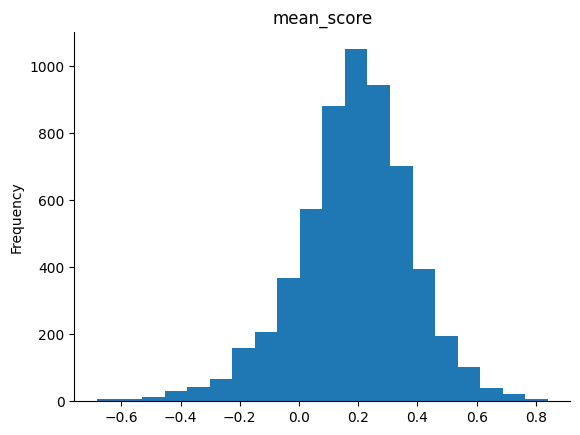

In [ ]:
from matplotlib import pyplot as plt
_df_16['mean_score'].plot(kind='hist', bins=20, title='mean_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

,token,counts
0,AGAGTGAGAC,1
1,TAACTTGC,1
2,AGTCAGTC,1
3,ACTTAA,1
4,TGATTGG,1
...,...,...
5812,AAAGTTTAA,1
5813,TCATCCG,1
5814,ATACATATT,1
5815,AATCAGAC,1


In [ ]:
sorted(token_means)[::-1][:50]

[(0.8491658699225735, 'TGGAGCCC'),
 (0.8476220301823704, 'ACCCAGAAG'),
 (0.8216142043693756, 'AATTTGCC'),
 (0.8176683828259427, 'TCTGTTTC'),
 (0.8153427331965908, 'AGAGGAAGG'),
 (0.804312421862748, 'ATGTAGG'),
 (0.7836347102541656, 'TGTCTTC'),
 (0.7832400877678517, 'TTTTGGGGG'),
 (0.7824706311103264, 'AAGTTCCC'),
 (0.7789549513668175, 'AAAATGGC'),
 (0.7783842635013825, 'TTCCCACC'),
 (0.7761862088541843, 'AGCTGAAGC'),
 (0.773284368217828, 'TTCCTCCTCC'),
 (0.770307076652619, 'TCTTCTCTC'),
 (0.764035527267134, 'TTTGCTTTC'),
 (0.7639335864850456, 'TTTCCTTTC'),
 (0.754594152147437, 'AGTTTCTGC'),
 (0.7541711228871124, 'TGATGGC'),
 (0.7507324311975495, 'TGTTACG'),
 (0.7465396915787506, 'TTTCTTG'),
 (0.7433426858053311, 'AGTGGGGGC'),
 (0.7424284265502784, 'TTTCTCCC'),
 (0.7409350622597285, 'AGAAGAGAAG'),
 (0.7386482853210344, 'AAAGCAGCC'),
 (0.738240799178783, 'TTGGTATG'),
 (0.7308610805867107, 'AGCTGGAC'),
 (0.7302849590299171, 'TAAGGGGG'),
 (0.7293036621388639, 'TGCACTTTC'),
 (0.728615036210

In [ ]:
sorted(token_means)[:50]

[(-0.8398624812749133, 'AATCTAAC'),
 (-0.7666907143017144, 'TTATAAC'),
 (-0.7483843358168958, 'TATAAGGC'),
 (-0.7225598946355892, 'CCCTAA'),
 (-0.6945417627219926, 'ACCAGGCCCC'),
 (-0.676001363463324, 'TGATTGG'),
 (-0.6547205399364904, 'AATTAA'),
 (-0.6476019939257761, 'TCAGGAGGCTGAGG'),
 (-0.635677035371786, 'ACACATG'),
 (-0.6353589330126276, 'ATCCAGCC'),
 (-0.6309616455259258, 'AGTCATAA'),
 (-0.617919023536509, 'AAGAGCC'),
 (-0.6094700282828005, 'TATCG'),
 (-0.6079730785842578, 'ATTAGG'),
 (-0.603160232148707, 'TTAGGCG'),
 (-0.6021763932195532, 'AAACCG'),
 (-0.5963490249179269, 'ATATATAA'),
 (-0.5945885036004646, 'AGAGTCAAG'),
 (-0.5900884288119997, 'ATTTTAA'),
 (-0.5859068068437114, 'TATGGTAA'),
 (-0.5851868398212635, 'ATAACG'),
 (-0.5834103731399852, 'TTAATAGC'),
 (-0.5833228824063919, 'AGAGAGC'),
 (-0.5810957186400212, 'ACACTGG'),
 (-0.5654491141446744, 'TTAGCCG'),
 (-0.5620244473193784, 'TTTAGCG'),
 (-0.5584459328441688, 'ATCGCG'),
 (-0.5553718881896663, 'TAAGGCC'),
 (-0.54977177

In [ ]:
!pip install shap

In [ ]:
import transformers
import shap

In [ ]:
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
explainer = shap.Explainer(pred)

['GCAATAAAAGGCTTAGCCACATAGTGCATGCAGAGCTCTGACTTCTAGGGCAAAACATAAGCATGTACAC',
 'ATTATATATGTCTATATTTTTTGCAGCCATTATGCAGATGTAGATCCTGAAAACCAGAACTTTTTACTTG',
 'TCTTTAAATACAAGTGAGTTTGGAGAAAAGAAAAAGGGGGAGAAGGGGGCAGAGTCACTTTTTTTCAGCG']

In [ ]:
shap_values = explainer(dataset['test']['sequence'][:3])

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:23<00:00,  3.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:29,  9.87s/it]


In [ ]:
dataset['test'][0]

{'sequence': 'GCAATAAAAGGCTTAGCCACATAGTGCATGCAGAGCTCTGACTTCTAGGGCAAAACATAAGCATGTACAC',
 'label': 0}

In [ ]:
shap.plots.text(shap_values)